## Set up

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import lightning.pytorch as pl
import torch
import pickle

from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor, plot_tree

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [10]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import the data

In [11]:
online_retail_df = pd.read_json('../../dataset/online_retail_data/online_retail.json')
online_retail_df

,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.00
...,...,...,...,...,...
73299,heart of wicker large,2010-12-05,94,261.30,2.78
73300,heart of wicker large,2010-12-06,34,118.06,3.47
73301,heart of wicker large,2010-12-07,462,1451.10,3.14
73302,heart of wicker large,2010-12-08,35,106.21,3.03


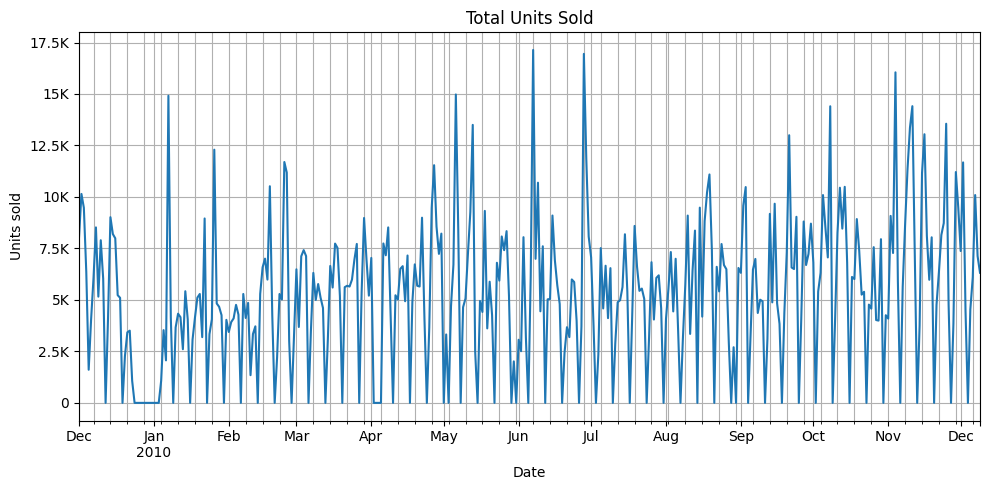

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['UnitsSold'].sum().plot(ax=ax)

ax.set_title('Total Units Sold')
ax.set_xlabel('Date')
ax.set_ylabel('Units sold')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

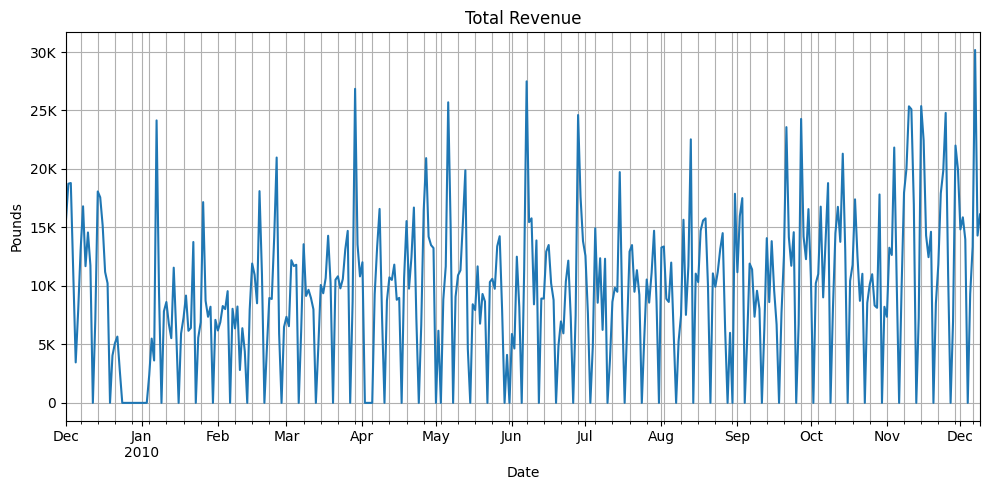

In [13]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['RevenuePounds'].sum().plot(ax=ax)

ax.set_title('Total Revenue')
ax.set_xlabel('Date')
ax.set_ylabel('Pounds')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

## Prepare the data

In [14]:
feature_dataset_df = online_retail_df[['Description', 'Date', 'UnitsSold', 'AveragePricePerUnitPounds', 'RevenuePounds']].copy()
feature_dataset_df['DayOfWeek_Str'] = feature_dataset_df['Date'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

feature_dataset_df['DayOfWeek_CatOrdered'] = pd.Categorical(
    feature_dataset_df['DayOfWeek_Str'], categories=ordered_days, ordered=True
)

feature_dataset_df['DayOfWeek_Numerical'] = feature_dataset_df['DayOfWeek_CatOrdered'].cat.codes

day_of_week_dummies_ordered = pd.get_dummies(
    feature_dataset_df['DayOfWeek_CatOrdered'], dtype=int
)

feature_dataset_df = pd.concat([feature_dataset_df, day_of_week_dummies_ordered], axis=1)
feature_dataset_df = feature_dataset_df.drop(columns=[
    'DayOfWeek_Str',
    'DayOfWeek_CatOrdered',
])

feature_dataset_df['DayOfMonth'] = feature_dataset_df['Date'].dt.day

feature_dataset_df['DayBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(1)
feature_dataset_df['TwoDaysBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(2)
feature_dataset_df['WeekBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(7)
feature_dataset_df['MonthBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(30)

feature_dataset_df = feature_dataset_df.fillna(0)

feature_dataset_df = feature_dataset_df.sort_values(by=['Description', 'Date'])

feature_dataset_df

,Description,Date,UnitsSold,AveragePricePerUnitPounds,RevenuePounds,DayOfWeek_Numerical,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,DayOfMonth,DayBefore,TwoDaysBefore,WeekBefore,MonthBefore
0,12 pencils small tube red spotty,2009-12-01,45,0.66,29.90,1,0,1,0,0,0,0,0,1,0.0,0.0,0.0,0.0
1,12 pencils small tube red spotty,2009-12-02,87,0.71,61.75,2,0,0,1,0,0,0,0,2,45.0,0.0,0.0,0.0
2,12 pencils small tube red spotty,2009-12-03,34,0.69,23.40,3,0,0,0,1,0,0,0,3,87.0,45.0,0.0,0.0
3,12 pencils small tube red spotty,2009-12-04,84,0.66,55.25,4,0,0,0,0,1,0,0,4,34.0,87.0,0.0,0.0
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.00,5,0,0,0,0,0,1,0,5,84.0,34.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53477,zinc metal heart decoration,2010-12-05,34,1.25,42.50,6,0,0,0,0,0,0,1,5,0.0,6.0,54.0,1.0
53478,zinc metal heart decoration,2010-12-06,33,1.52,50.07,0,1,0,0,0,0,0,0,6,34.0,0.0,82.0,0.0
53479,zinc metal heart decoration,2010-12-07,51,1.27,65.01,1,0,1,0,0,0,0,0,7,33.0,34.0,36.0,33.0
53480,zinc metal heart decoration,2010-12-08,20,1.31,26.26,2,0,0,1,0,0,0,0,8,51.0,33.0,27.0,81.0


In [87]:
last_date = feature_dataset_df['Date'].max() - timedelta(days=60)
train_df = feature_dataset_df[lambda x: x['Date'] <= last_date]
val_df = feature_dataset_df[lambda x: x['Date'] > last_date]

## Decision tree

In [88]:
def train_trees(train_df: pd.DataFrame, features: list[str], target: str, criterion: str = 'squared_error'):
    products = train_df['Description'].unique()
    tree_models = dict()
    for product in products:
        product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
        X_train, y_train = product_train_df[features], product_train_df[target]
        tree_models[product] = (
            DecisionTreeRegressor(random_state=42, criterion=criterion)
            .fit(X_train, y_train)
        )
    return tree_models

In [89]:
features = [
    'AveragePricePerUnitPounds',
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'DayOfMonth',
    'DayBefore', 'WeekBefore', 'MonthBefore',
]
target = 'UnitsSold'

tree_models = train_trees(train_df, features, target)

In [90]:
def get_autoregressive_predictions(
    tree_model: DecisionTreeRegressor,
    prev_values: pd.Series,
    known_future_prices_per_unit: pd.Series,
):
    """
    Performs an autogressive forecast using the tree.

    Args:
        tree_model: A trained DecisionTreeRegressor.
        prev_values: A Pandas series containing all known previous unit sales. The index
            should be the date.
        known_future_prices_per_unit: A Pandas series with the known price of the good
            during the dates to forecast. Should have dates as index.
    Returns:
        A series representing the predictions for the next number of days.
    """
    values = prev_values.sort_index()
    known_future_prices_per_unit = known_future_prices_per_unit.sort_index()
    for date in known_future_prices_per_unit.index:
        price = known_future_prices_per_unit.loc[date]
        
        is_monday = date.dayofweek == 0
        is_tuesday = date.dayofweek == 1
        is_wednesday = date.dayofweek == 2
        is_thursday = date.dayofweek == 3
        is_friday = date.dayofweek == 4
        is_saturday = date.dayofweek == 5
        is_sunday = date.dayofweek == 6

        day_of_month = date.day
        
        prev_day = values.loc[date - timedelta(days=1)]
        prev_week = values.loc[date - timedelta(days=7)]
        prev_month = values.loc[date - timedelta(days=30)]
        
        X = np.array([[
            price,
            is_monday,
            is_tuesday,
            is_wednesday,
            is_thursday,
            is_friday,
            is_saturday,
            is_sunday,
            day_of_month,
            prev_day,
            prev_week,
            prev_month
        ]])
        pred = round(tree_model.predict(X)[0])
        values[date] = pred
    return values.loc[known_future_prices_per_unit.index]
        
def get_predictions_for_product(tree_model, all_values, known_future_prices_per_unit, forecast_len = 7):
    all_values = all_values.sort_index()
    known_future_prices_per_unit = known_future_prices_per_unit.sort_index()
    predictions_df = pd.DataFrame(columns=range(1, forecast_len + 1), index=known_future_prices_per_unit.index)
    for date in known_future_prices_per_unit.index:
        end_date = date+timedelta(days=forecast_len)
        preds = get_autoregressive_predictions(
            tree_model,
            all_values.loc[:date],
            known_future_prices_per_unit.loc[date:end_date],
        )
        np.fill_diagonal(predictions_df.loc[date:end_date,:len(preds)].values, preds)
    results_df = predictions_df.copy()
    results_df['observed'] = all_values.loc[known_future_prices_per_unit.index]
    return results_df.reset_index()

def get_predictions(tree_models, train_df, val_df, forecast_len = 7):
    products = val_df['Description'].unique()
    dfs = list()
    for product in tqdm(products):
        if product not in tree_models:
            print(f'Warning: Found no model for "{product}"')
            continue
        tree_model = tree_models[product]
        product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
        product_val_df = val_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
        all_values = pd.concat([product_train_df['UnitsSold'], product_val_df['UnitsSold']], axis=0).sort_index()
        known_future_prices_per_unit = product_val_df['AveragePricePerUnitPounds'].sort_index()

        results_df = get_predictions_for_product(tree_models[product], all_values, known_future_prices_per_unit)
        results_df.insert(0, 'Product', product)
        dfs.append(results_df.copy())
    return pd.concat(dfs, axis=0, ignore_index=True).reset_index(drop=True)

In [91]:
results_df = get_predictions(tree_models, train_df, val_df)
results_df

100%|█████████████████████████████████████████| 196/196 [00:30<00:00,  6.36it/s]


,Product,Date,1,2,3,4,5,6,7,observed
0,12 pencils small tube red spotty,2010-10-11,25,NaN,NaN,NaN,NaN,NaN,NaN,18
1,12 pencils small tube red spotty,2010-10-12,1251,1251,NaN,NaN,NaN,NaN,NaN,584
2,12 pencils small tube red spotty,2010-10-13,84,84,84,NaN,NaN,NaN,NaN,52
3,12 pencils small tube red spotty,2010-10-14,34,34,34,34,NaN,NaN,NaN,49
4,12 pencils small tube red spotty,2010-10-15,799,799,799,799,799,NaN,NaN,55
...,...,...,...,...,...,...,...,...,...,...
11755,zinc metal heart decoration,2010-12-05,48,48,48,48,48,48,48,34
11756,zinc metal heart decoration,2010-12-06,32,32,32,32,32,32,32,33
11757,zinc metal heart decoration,2010-12-07,63,63,63,63,63,63,63,51
11758,zinc metal heart decoration,2010-12-08,52,52,52,52,52,52,52,20


In [92]:
def calculated_ape_for_row(row, forecast_len = 7):
    numerator = np.abs(row.loc[1:forecast_len] - row.loc['observed'])
    denominator = row.loc['observed']
    ape = numerator / (denominator + 1e-16)
    return ape

ape_df = results_df.set_index(['Date', 'Product']).apply(calculated_ape_for_row, axis=1).reset_index()
ape_df

,Date,Product,1,2,3,4,5,6,7
0,2010-10-11,12 pencils small tube red spotty,0.388889,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-10-12,12 pencils small tube red spotty,1.142123,1.142123,NaN,NaN,NaN,NaN,NaN
2,2010-10-13,12 pencils small tube red spotty,0.615385,0.615385,0.615385,NaN,NaN,NaN,NaN
3,2010-10-14,12 pencils small tube red spotty,0.306122,0.306122,0.306122,0.306122,NaN,NaN,NaN
4,2010-10-15,12 pencils small tube red spotty,13.527273,13.527273,13.527273,13.527273,13.527273,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11755,2010-12-05,zinc metal heart decoration,0.411765,0.411765,0.411765,0.411765,0.411765,0.411765,0.411765
11756,2010-12-06,zinc metal heart decoration,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303
11757,2010-12-07,zinc metal heart decoration,0.235294,0.235294,0.235294,0.235294,0.235294,0.235294,0.235294
11758,2010-12-08,zinc metal heart decoration,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000


In [93]:
mape_df = ape_df.drop(columns=['Date']).groupby('Product').mean()
mape_df

,1,2,3,4,5,6,7
Product,,,,,,,
12 pencils small tube red spotty,2.228474,1.789892,1.683233,1.709453,1.722268,1.507631,1.535550
12 pencils tall tube posy,1.484795,1.605616,1.633299,1.661953,1.602345,1.621089,1.651109
12 pencils tall tube woodland,3.161000,2.729054,3.155210,4.353028,2.692160,2.303675,2.346336
3 stripey mice feltcraft,1.614822,1.215740,1.264456,1.020869,1.039099,1.003446,1.022028
6 ribbons rustic charm,0.484661,0.528873,0.531051,0.539406,0.524715,0.523999,0.533703
...,...,...,...,...,...,...,...
wooden picture frame white finish,0.622997,0.627454,0.641967,0.632496,0.639669,0.650969,0.663024
wooden school colouring set,0.991425,0.984314,0.989349,1.006706,0.999683,0.998162,1.016647
woodland charlotte bag,1.010178,1.184248,1.204667,1.225004,1.204021,1.225427,1.248120


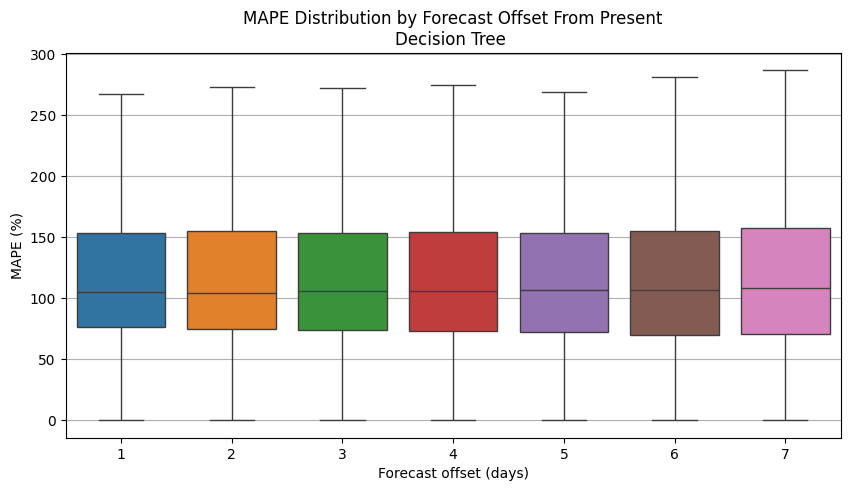

In [169]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=mape_df * 100, showfliers=False, ax=ax)

ax.set_title('MAPE Distribution by Forecast Offset From Present\nDecision Tree ')
ax.set_xlabel('Forecast offset (days)')
ax.set_ylabel('MAPE (%)')
ax.yaxis.grid(True)

In [95]:
mape_df[1].describe()

count    1.960000e+02
mean     1.539116e+14
std      1.859673e+15
min      0.000000e+00
25%      7.612002e-01
50%      1.050297e+00
75%      1.537030e+00
max      2.566667e+16
Name: 1, dtype: float64

In [96]:
q1 = mape_df[1].quantile(0.25)
q3 = mape_df[1].quantile(0.75)

q1_products = mape_df[1][lambda x: x <= q1]
mid_products = mape_df[1][lambda x: (q1 < x) & (x < q3)]
q3_products = mape_df[1][lambda x: x >= q3]

q1_products_sample = q1_products.sample(n=4, replace=False, random_state=42).sort_values()
mid_products_sample = mid_products.sample(n=4, replace=False, random_state=42).sort_values()
q3_products_sample = q3_products.sample(n=4, replace=False, random_state=42).sort_values()

In [97]:
train_df

,Description,Date,UnitsSold,AveragePricePerUnitPounds,RevenuePounds,DayOfWeek_Numerical,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,DayOfMonth,DayBefore,TwoDaysBefore,WeekBefore,MonthBefore
0,12 pencils small tube red spotty,2009-12-01,45,0.66,29.90,1,0,1,0,0,0,0,0,1,0.0,0.0,0.0,0.0
1,12 pencils small tube red spotty,2009-12-02,87,0.71,61.75,2,0,0,1,0,0,0,0,2,45.0,0.0,0.0,0.0
2,12 pencils small tube red spotty,2009-12-03,34,0.69,23.40,3,0,0,0,1,0,0,0,3,87.0,45.0,0.0,0.0
3,12 pencils small tube red spotty,2009-12-04,84,0.66,55.25,4,0,0,0,0,1,0,0,4,34.0,87.0,0.0,0.0
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.00,5,0,0,0,0,0,1,0,5,84.0,34.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53417,zinc metal heart decoration,2010-10-06,0,0.00,0.00,2,0,0,1,0,0,0,0,6,48.0,36.0,83.0,16.0
53418,zinc metal heart decoration,2010-10-07,302,1.11,336.46,3,0,0,0,1,0,0,0,7,0.0,48.0,0.0,24.0
53419,zinc metal heart decoration,2010-10-08,12,1.25,15.00,4,0,0,0,0,1,0,0,8,302.0,0.0,49.0,24.0
53420,zinc metal heart decoration,2010-10-09,0,0.00,0.00,5,0,0,0,0,0,1,0,9,12.0,302.0,0.0,24.0


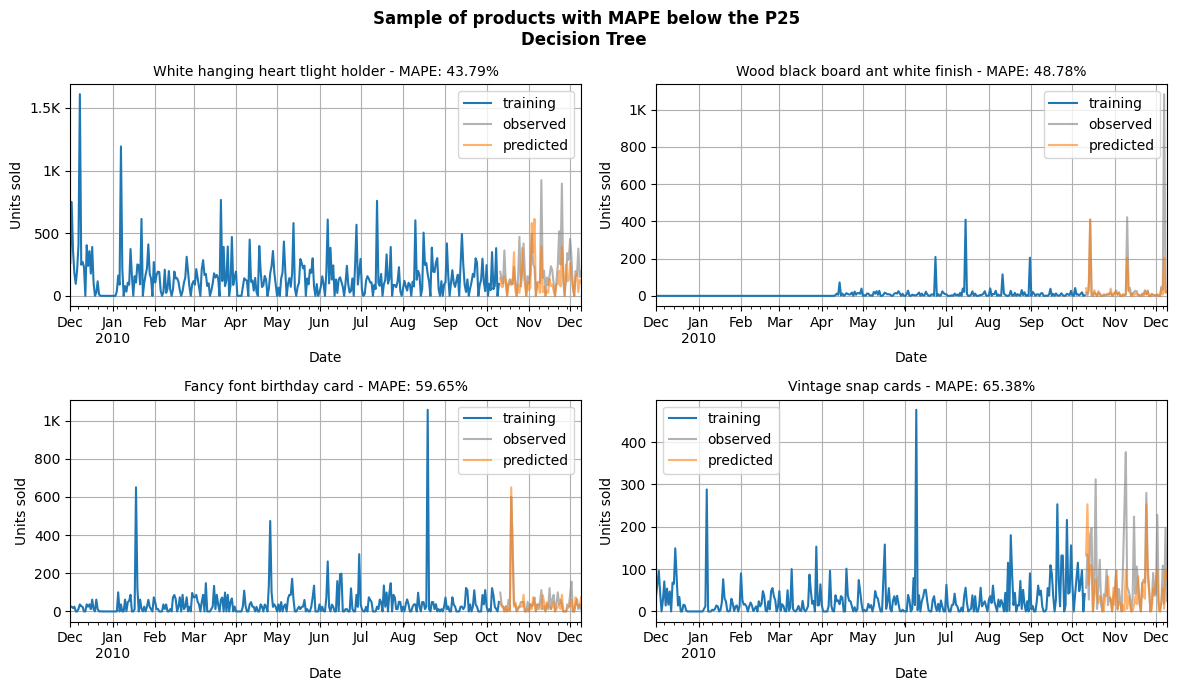

In [170]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Sample of products with MAPE below the P25\nDecision Tree ', fontweight='bold')

for ax, product in zip(axs.flatten(), q1_products_sample.index):
    mape = round(q1_products_sample.loc[product] * 100, 2)

    train_series = train_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    val_series = val_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    pred_series = results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()

    train_series.plot(ax=ax, color='tab:blue', label='training')
    val_series.plot(ax=ax, color='tab:grey', alpha=0.6, label='observed')
    pred_series.plot(ax=ax, color='tab:orange', alpha=0.6, label='predicted')

    ax.set_title(f'{product.capitalize()} - MAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Units sold')
    ax.grid(True)
    ax.legend()
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

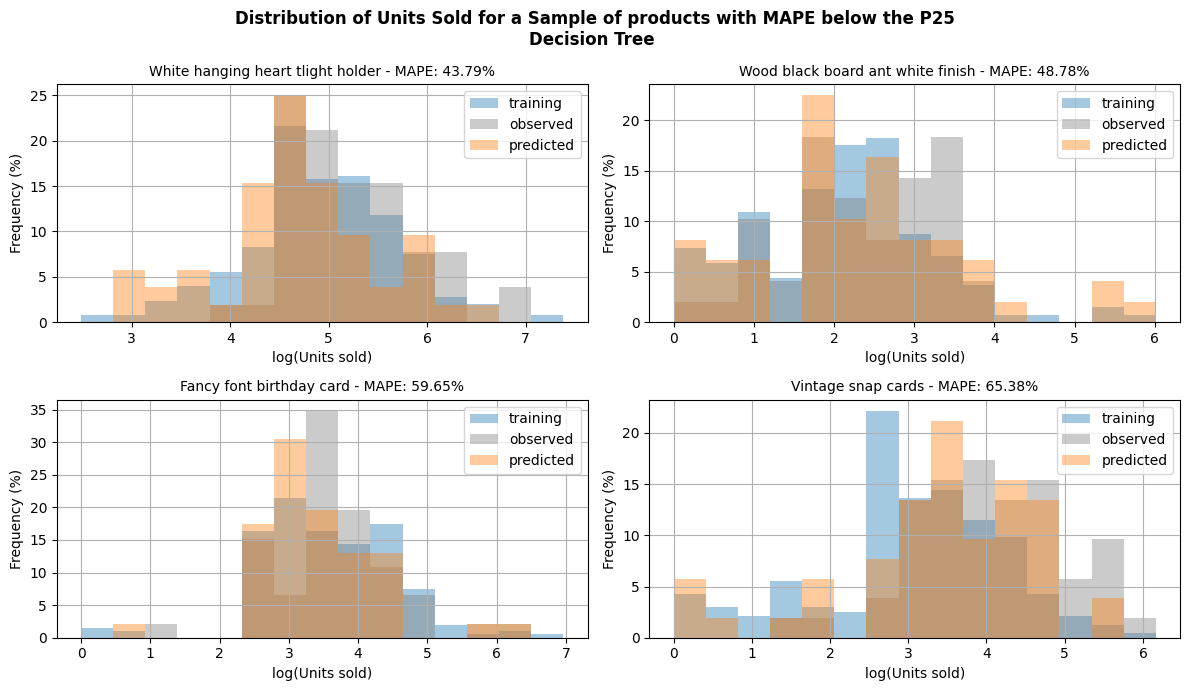

In [172]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Distribution of Units Sold for a Sample of products with MAPE below the P25\nDecision Tree ', fontweight='bold')

for ax, product in zip(axs.flatten(), q1_products_sample.index):
    mape = round(q1_products_sample.loc[product] * 100, 2)

    train_series = np.log(train_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    val_series = np.log(val_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    pred_series = np.log(results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()[lambda x: x > 0].astype(float))

    # Calculate frequencies for percentage conversion
    train_counts, train_bins = np.histogram(train_series, bins=15)
    train_probs = train_counts / len(train_series) * 100
    val_counts, val_bins = np.histogram(val_series, bins=train_bins) # Use the same bins for comparison
    val_probs = val_counts / len(val_series) * 100
    pred_counts, pred_bins = np.histogram(pred_series, bins=train_bins) # Use the same bins for comparison
    pred_probs = pred_counts / len(pred_series) * 100

    ax.bar(train_bins[:-1], train_probs, width=np.diff(train_bins), align='edge', color='tab:blue', alpha=0.4, label='training')
    ax.bar(val_bins[:-1], val_probs, width=np.diff(val_bins), align='edge', color='tab:grey', alpha=0.4, label='observed')
    ax.bar(pred_bins[:-1], pred_probs, width=np.diff(pred_bins), align='edge', color='tab:orange', alpha=0.4, label='predicted')

    ax.set_title(f'{product.capitalize()} - MAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('log(Units sold)')
    ax.set_ylabel('Frequency (%)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

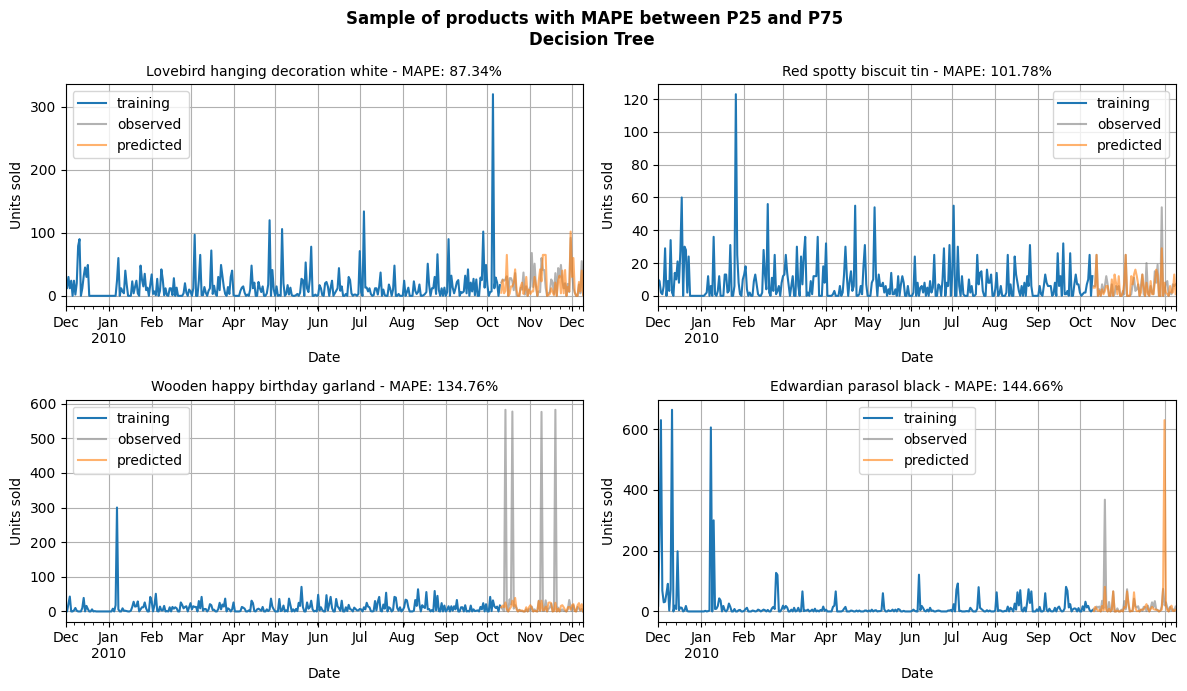

In [173]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Sample of products with MAPE between P25 and P75\nDecision Tree ', fontweight='bold')

for ax, product in zip(axs.flatten(), mid_products_sample.index):
    mape = round(mid_products_sample.loc[product] * 100, 2)

    train_series = train_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    val_series = val_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    pred_series = results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()

    train_series.plot(ax=ax, color='tab:blue', label='training')
    val_series.plot(ax=ax, color='tab:grey', alpha=0.6, label='observed')
    pred_series.plot(ax=ax, color='tab:orange', alpha=0.6, label='predicted')

    ax.set_title(f'{product.capitalize()} - MAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Units sold')
    ax.grid(True)
    ax.legend()
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

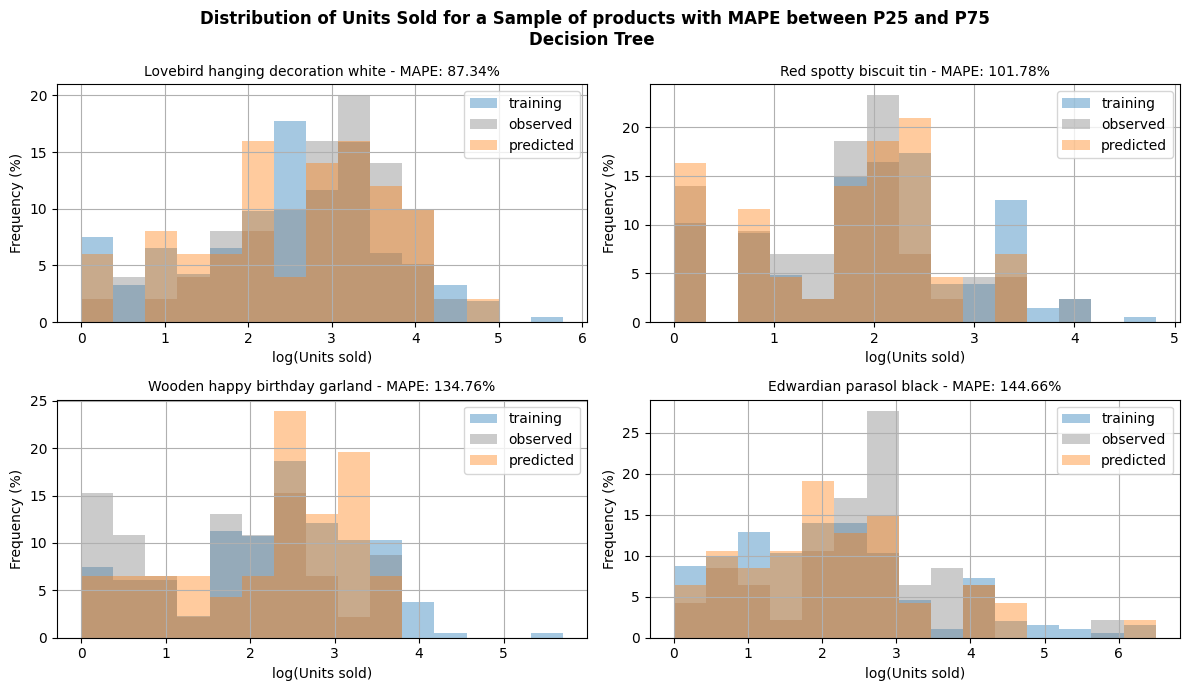

In [174]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Distribution of Units Sold for a Sample of products with MAPE between P25 and P75\nDecision Tree ', fontweight='bold')

for ax, product in zip(axs.flatten(), mid_products_sample.index):
    mape = round(mid_products_sample.loc[product] * 100, 2)

    train_series = np.log(train_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    val_series = np.log(val_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    pred_series = np.log(results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()[lambda x: x > 0].astype(float))

    # Calculate frequencies for percentage conversion
    train_counts, train_bins = np.histogram(train_series, bins=15)
    train_probs = train_counts / len(train_series) * 100
    val_counts, val_bins = np.histogram(val_series, bins=train_bins) # Use the same bins for comparison
    val_probs = val_counts / len(val_series) * 100
    pred_counts, pred_bins = np.histogram(pred_series, bins=train_bins) # Use the same bins for comparison
    pred_probs = pred_counts / len(pred_series) * 100

    ax.bar(train_bins[:-1], train_probs, width=np.diff(train_bins), align='edge', color='tab:blue', alpha=0.4, label='training')
    ax.bar(val_bins[:-1], val_probs, width=np.diff(val_bins), align='edge', color='tab:grey', alpha=0.4, label='observed')
    ax.bar(pred_bins[:-1], pred_probs, width=np.diff(pred_bins), align='edge', color='tab:orange', alpha=0.4, label='predicted')

    ax.set_title(f'{product.capitalize()} - MAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('log(Units sold)')
    ax.set_ylabel('Frequency (%)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

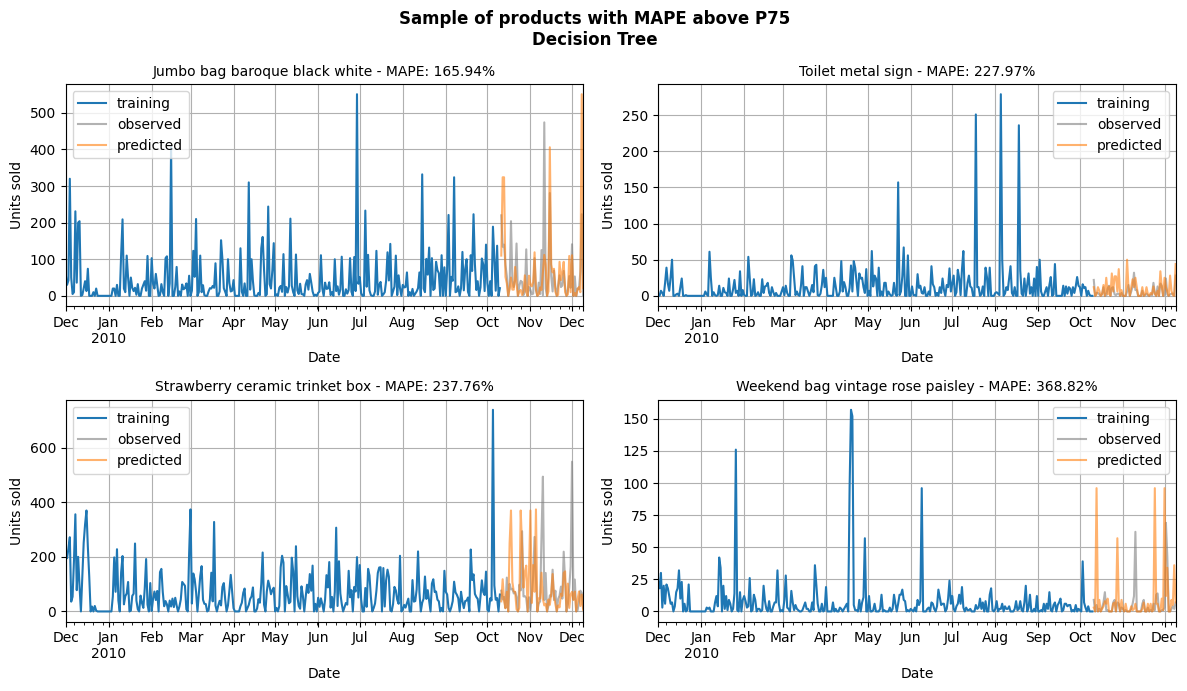

In [176]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Sample of products with MAPE above P75\nDecision Tree', fontweight='bold')

for ax, product in zip(axs.flatten(),q3_products_sample.index):
    mape = round(q3_products_sample.loc[product] * 100, 2)

    train_series = train_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    val_series = val_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    pred_series = results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()

    train_series.plot(ax=ax, color='tab:blue', label='training')
    val_series.plot(ax=ax, color='tab:grey', alpha=0.6, label='observed')
    pred_series.plot(ax=ax, color='tab:orange', alpha=0.6, label='predicted')

    ax.set_title(f'{product.capitalize()} - MAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Units sold')
    ax.grid(True)
    ax.legend()
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

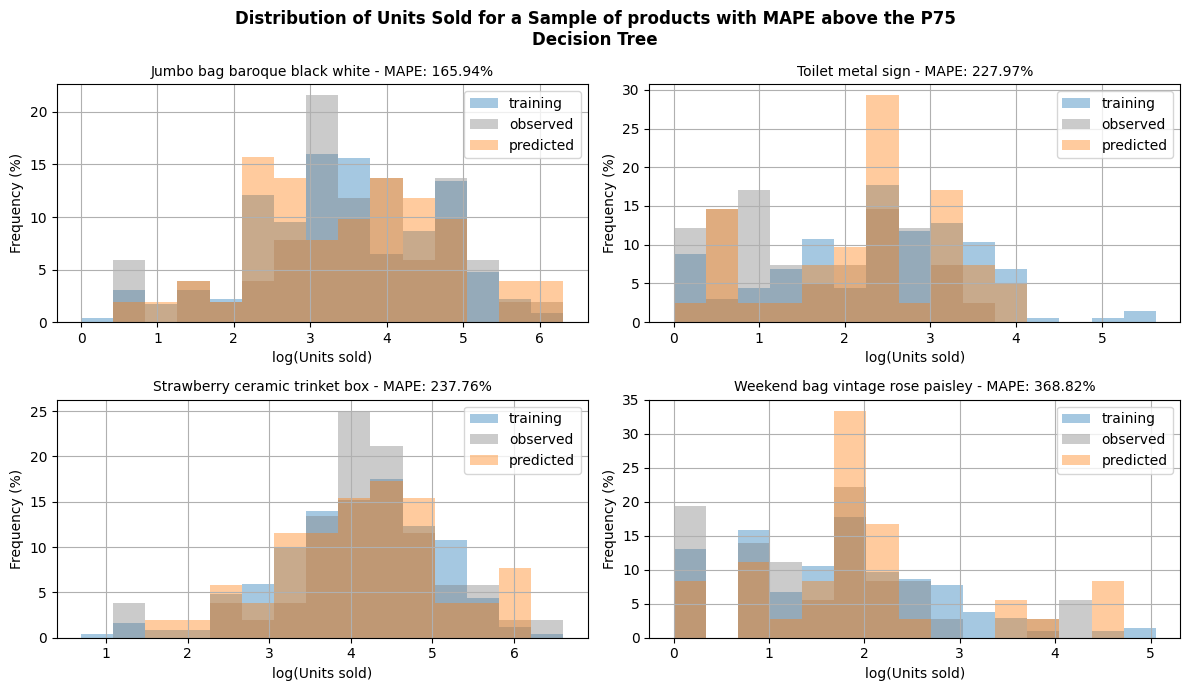

In [177]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

fig.suptitle('Distribution of Units Sold for a Sample of products with MAPE above the P75\nDecision Tree', fontweight='bold')

for ax, product in zip(axs.flatten(), q3_products_sample.index):
    mape = round(q3_products_sample.loc[product] * 100, 2)

    train_series = np.log(train_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    val_series = np.log(val_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index())
    pred_series = np.log(results_df.query(f'Product == "{product}"').set_index('Date')[1].sort_index()[lambda x: x > 0].astype(float))

    # Calculate frequencies for percentage conversion
    train_counts, train_bins = np.histogram(train_series, bins=15)
    train_probs = train_counts / len(train_series) * 100
    val_counts, val_bins = np.histogram(val_series, bins=train_bins) # Use the same bins for comparison
    val_probs = val_counts / len(val_series) * 100
    pred_counts, pred_bins = np.histogram(pred_series, bins=train_bins) # Use the same bins for comparison
    pred_probs = pred_counts / len(pred_series) * 100

    ax.bar(train_bins[:-1], train_probs, width=np.diff(train_bins), align='edge', color='tab:blue', alpha=0.4, label='training')
    ax.bar(val_bins[:-1], val_probs, width=np.diff(val_bins), align='edge', color='tab:grey', alpha=0.4, label='observed')
    ax.bar(pred_bins[:-1], pred_probs, width=np.diff(pred_bins), align='edge', color='tab:orange', alpha=0.4, label='predicted')

    ax.set_title(f'{product.capitalize()} - MAPE: {mape:.2f}%', fontsize=10)
    ax.set_xlabel('log(Units sold)')
    ax.set_ylabel('Frequency (%)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [156]:
mape_by_dayofweek = ape_df[['Date', 'Product', 1]].copy()
mape_by_dayofweek['DayOfWeek'] = mape_by_dayofweek['Date'].dt.day_name()
mape_by_dayofweek = mape_by_dayofweek.groupby(['DayOfWeek', 'Product'])[1].mean() * 100
mape_by_dayofweek = mape_by_dayofweek.reset_index()
mape_by_dayofweek = mape_by_dayofweek.rename(columns={1: 'MAPE'})

mape_by_dayofweek

,DayOfWeek,Product,MAPE
0,Friday,12 pencils small tube red spotty,457.726822
1,Friday,12 pencils tall tube posy,97.839952
2,Friday,12 pencils tall tube woodland,397.779699
3,Friday,3 stripey mice feltcraft,211.747547
4,Friday,6 ribbons rustic charm,49.104259
...,...,...,...
1367,Wednesday,wooden picture frame white finish,100.786602
1368,Wednesday,wooden school colouring set,69.208215
1369,Wednesday,woodland charlotte bag,100.806075
1370,Wednesday,world war 2 gliders asstd designs,256.942664


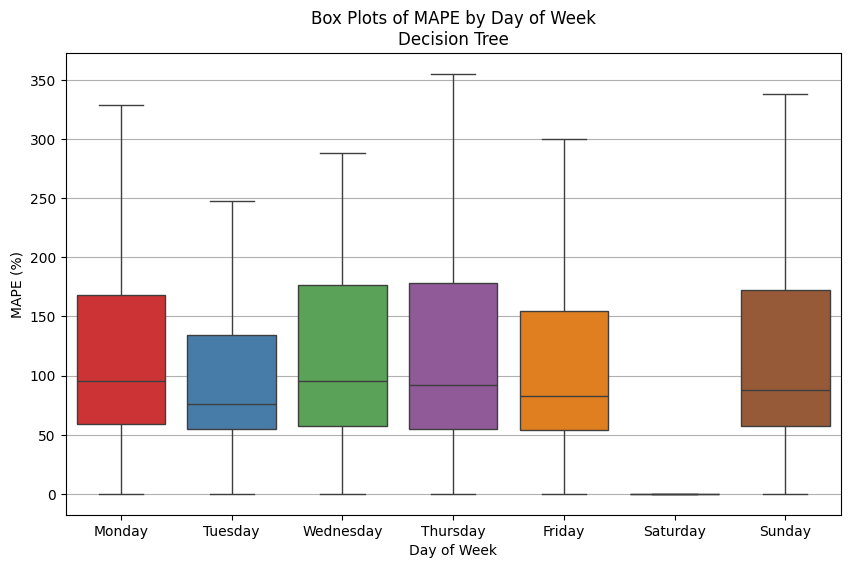

In [178]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='DayOfWeek', y='MAPE', data=mape_by_dayofweek, order=day_order, showfliers=False, palette='Set1')

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('MAPE (%)')
plt.title('Box Plots of MAPE by Day of Week\nDecision Tree')
plt.grid(axis='y')

# Show the plot
plt.show()